In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm


# Define constants
H_0 = 70  # km/s/Mpc
c = 2.99792458e5  # km/s
M = -19.3146267582  # M
M_n = 25 - 5*np.log10(H_0) #Script_M
Omega_R = 1e-8

#Initial guesses for cosmological parameters
Omega_M = 0.27
Omega_DE = 0.73
w = -1

In [78]:
# supernova data

data = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\t', comment='#', usecols=[0, 1, 2, 3], names=['SNe', 'z', 'm', 'm_err'])


# Load the covariance matrix

data_cov = pd.read_csv('SCPUnion2.1_covmat_nosys.txt', sep='\s+', header=None)

data

,SNe,z,m,m_err
0,1993ah,0.028488,35.346583,0.223906
1,1993ag,0.050043,36.682368,0.166829
2,1993o,0.052926,36.817691,0.155756
3,1993b,0.070086,37.446737,0.158467
4,1992bs,0.062668,37.483409,0.156099
...,...,...,...,...
575,D-000,1.017000,44.293971,0.171046
576,D-006,1.315000,44.971358,0.187509
577,P-009,0.821000,43.640939,0.194014
578,R-012,1.215000,45.246521,0.560317


In [79]:
#Calculation of r(z)

def integrand(z, Omega_M, Omega_DE, w):
    return 1 / np.sqrt(Omega_M * (1 + z)**3 + Omega_DE * (1 + z)**(3 * (1 + w)) + Omega_R * (1 + z)**(4))

def r(z, Omega_M, Omega_DE, w):
    return c / H_0 * quad(integrand, 0, z, args=(Omega_M, Omega_DE, w))[0]

In [80]:
#calculation of d_l

def d_L(z, Omega_M, Omega_DE, w):
    return (1 + z) * r(z, Omega_M, Omega_DE, w)

In [81]:
#calculation of m(z, {pj})

def m_th(z, Omega_M, Omega_DE, w):
    return 5 * np.log10(H_0*d_L(z, Omega_M, Omega_DE, w)) + M_n

In [82]:
#calculation of (m - m^th)
def m_diff_vector(z, Omega_M, Omega_DE, w):

    data['m_th'] = data['z'].apply(lambda z: m_th(z, Omega_M, Omega_DE, w))
    data['m_diff'] = data['m'] - data['m_th']
    return data['m_diff']

m_diff_vector(data['z'], Omega_M, Omega_DE, w)

0     -0.133681
1     -0.056602
2     -0.047548
3     -0.055550
4      0.235743
         ...   
575    0.108311
576    0.088298
577    0.034675
578    0.578087
579   -0.351406
Name: m_diff, Length: 580, dtype: float64

In [83]:
def chi_squared(cov, Omega_M, Omega_DE, w):
# Convert the covariance matrix to a numpy array
    cov_matrix = cov

    # Invert the covariance matrix
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate the chi-squared value
    chi_squared = np.dot(data['m_diff'], np.dot(inv_cov_matrix, m_diff_vector(data['z'], Omega_M, Omega_DE, w)))

    return chi_squared

chi_squared(data_cov.values, Omega_M, Omega_DE, w)

562.5725706154857

In [84]:
def log_likelihood(cov, Omega_M, Omega_DE, w):
    # Calculate the log of the determinant and the sign of the determinant for the regularized matrix
    sign, log_det = np.linalg.slogdet(cov)

    n = cov.shape[0]

    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det - 0.5 * chi_squared(data_cov.values, Omega_M, Omega_DE, w)

    return log_likelihood

log_likelihood(data_cov.values, Omega_M, Omega_DE, w)

118.56730964066429

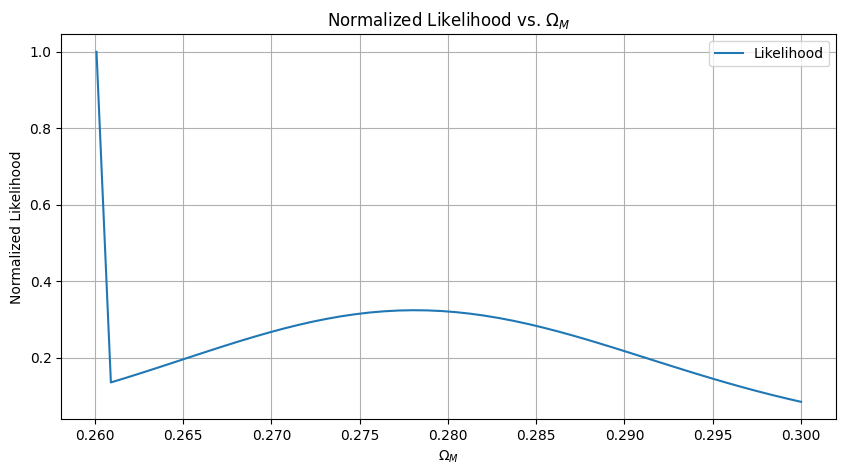

In [98]:
# Case #1 (Varying Omega_M)

# Make array of likelihoods, normalize to have a peak of 1
omega_m_range = np.linspace(0.2601, 0.3, 50)

likelihoods = np.array([log_likelihood(data_cov.values, omega_m, 1 - omega_m, w) for omega_m in omega_m_range])

likelihoods_norm = np.exp(likelihoods - np.max(likelihoods))

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_norm, label='Likelihood')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

# # Define the negative log-likelihood function

# L = 

# # Initial guess for the parameters
# initial_guess = [Omega_M, Omega_DE, w]

# # Find the parameters that minimize the negative log-likelihood
# result = minimize(neg_log_likelihood, initial_guess)

# # Print the result
# print("Estimated parameters: ", result.x)